In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re

import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1)

# Any results you write to the current directory are saved as output.

<ipython-input-1-9501c12dbd28>:28: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


> ## **Exploratory Data Analysis:**

In [2]:
lines = pd.read_csv("news-commentary-v15.en-ru.tsv",sep='\t',names=["English","Russian"])
lines.shape

(319228, 2)

In [3]:
pd.isnull(lines).sum()

English    10389
Russian    8301 
dtype: int64

In [4]:
lines=lines[~pd.isnull(lines['English'])]
lines=lines[~pd.isnull(lines['Russian'])]

In [5]:
lines.drop_duplicates(inplace=True)

In [6]:
pd.isnull(lines).sum()

English    0
Russian    0
dtype: int64

In [7]:
lines.shape

(304584, 2)

> ## **Data Pre-Processing 1:**
*  Here we select 60000 rows randomly from the dataset. (20% of training data)
*  We lowercase all the characters. 
*  We remove quotes, special characters, digits and extra spaces.
*  We add START and END tokens to each line in the dataset.





In [8]:
lines=lines.sample(n= 60000,random_state=42)
lines.shape

(60000, 2)

In [9]:
# Lowercase all characters
lines['English']=lines['English'].apply(lambda x: x.lower())
lines['Russian']=lines['Russian'].apply(lambda x: x.lower())

# Remove quotes
lines['English']=lines['English'].apply(lambda x: re.sub("'", '', x))
lines['Russian']=lines['Russian'].apply(lambda x: re.sub("'", '', x))

# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
lines['English']= lines['English'].apply(lambda x: x.translate(remove_digits))
lines['Russian'] = lines['Russian'].apply(lambda x: re.sub("[1234567890]", "", x))

exclude = set(string.punctuation) # Set of all special characters
# Remove all the special characters
lines['English']=lines['English'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines['Russian']=lines['Russian'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

# Remove extra spaces
lines['English']=lines['English'].apply(lambda x: x.strip())
lines['Russian']=lines['Russian'].apply(lambda x: x.strip())
lines['English']=lines['English'].apply(lambda x: re.sub(" +", " ", x))
lines['Russian']=lines['Russian'].apply(lambda x: re.sub(" +", " ", x))

# Add start and end tokens to target sequences
lines['Russian'] = lines['Russian'].apply(lambda x : 'START_ '+ x + ' _END')

In [10]:
lines.head()

,English,Russian
109136,it was ruled unconstitutional but it began a process of budget consolidation,START_ он не соответствовал конституции но положил начало процессу консолидации бюджета _END
253831,the stranger consciously or unconsciously is always a potential or partial exile and all real writers are perpetual exiles from this world even when like proust they hardly leave their rooms,START_ посторонний человек сознательно или бессознательно всегда потенциальный или частичный изгнанник а все настоящие писатели вечные изгнанники из этого мира даже когда они подобно прусту лишь изредка выходят из дома _END
3832,this would augment the diplomatic and moral capital available to diplomats as they strive to restrain nuclear proliferation in a world where more countries than ever have the wherewithal to construct a nuclear bomb,START_ ядерные державы должны придерживаться требований договора о нераспространении ядерного оружия года и возобновить добросовестные переговоры относительно разоружения это бы нарастило дипломатический и моральный капитал доступный дипломатам поскольку они стремятся ограничить распространение ядерного оружия в мире где у большего чем когдалибо числа стран есть средства чтобы создать ядерную бомбу _END
230123,it was the credibility of the united states’ threat of military intervention that seems to have led syrian president bashar alassad to cut a deal brokered by his main allies russia and less directly iran,START_ судя по всему именно вера в угрозу военного вмешательства сша привела сирийского президента башара альасада к заключению сделки при посредничестве своих главных союзников россии и менее непосредственно ирана _END
170530,in discussing this issue what constitutes modernization is often confused with westernization understanding the difference is vital,START_ при обсуждении этого вопроса однако модернизацию очень часто ошибочно принимают за вестернизацию в то время как совершенно необходимо понимать разницу между этими двумя концепциями _END


In [11]:
# Get English and Russian Vocabulary
all_eng_words=set()
for eng in lines['English']:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)

all_rus_words=set()
for rus in lines['Russian']:
    for word in rus.split():
        if word not in all_rus_words:
            all_rus_words.add(word)

In [12]:
len(all_eng_words)

45257

In [13]:
len(all_rus_words)

99936

In [14]:
lines['length_eng_sentence']= lines['English'].apply(lambda x:len(x.split(" ")))
lines['length_rus_sentence']= lines['Russian'].apply(lambda x:len(x.split(" ")))

In [72]:
lines['English'][5]

'so far the us has handled the various forms of political transition in the arab spring without severely damaging missteps'

In [56]:
lines.reset_index(inplace=True)

In [74]:
# count=0
# def Check_Vow(string, vowels,count):
#     final= [each for each in string if each in vowels]
#     b=len(final)
#     print(b)
# #     print(len(final))
# #     print(final)
     
# # Driver Code
# string = lines['English']
# vowels = "AaEeIiOoUu"
# for i in range(60):
#     Check_Vow(lines['English'][i], vowels,a);
# print(a)

In [15]:
lines.head()

,English,Russian,length_eng_sentence,length_rus_sentence
109136,it was ruled unconstitutional but it began a process of budget consolidation,START_ он не соответствовал конституции но положил начало процессу консолидации бюджета _END,12,12
253831,the stranger consciously or unconsciously is always a potential or partial exile and all real writers are perpetual exiles from this world even when like proust they hardly leave their rooms,START_ посторонний человек сознательно или бессознательно всегда потенциальный или частичный изгнанник а все настоящие писатели вечные изгнанники из этого мира даже когда они подобно прусту лишь изредка выходят из дома _END,31,31
3832,this would augment the diplomatic and moral capital available to diplomats as they strive to restrain nuclear proliferation in a world where more countries than ever have the wherewithal to construct a nuclear bomb,START_ ядерные державы должны придерживаться требований договора о нераспространении ядерного оружия года и возобновить добросовестные переговоры относительно разоружения это бы нарастило дипломатический и моральный капитал доступный дипломатам поскольку они стремятся ограничить распространение ядерного оружия в мире где у большего чем когдалибо числа стран есть средства чтобы создать ядерную бомбу _END,34,50
230123,it was the credibility of the united states’ threat of military intervention that seems to have led syrian president bashar alassad to cut a deal brokered by his main allies russia and less directly iran,START_ судя по всему именно вера в угрозу военного вмешательства сша привела сирийского президента башара альасада к заключению сделки при посредничестве своих главных союзников россии и менее непосредственно ирана _END,35,30
170530,in discussing this issue what constitutes modernization is often confused with westernization understanding the difference is vital,START_ при обсуждении этого вопроса однако модернизацию очень часто ошибочно принимают за вестернизацию в то время как совершенно необходимо понимать разницу между этими двумя концепциями _END,17,26


In [16]:
lines= lines[lines['length_eng_sentence']<=20]
lines= lines[lines['length_rus_sentence']<=20]

In [17]:
lines.shape

(24889, 4)

In [18]:
print("Maximum length of Russian Sentence",max(lines['length_rus_sentence']))
print("maximum length of English Sentence",max(lines['length_eng_sentence']))

Maximum length of Russian Sentence 20
maximum length of English Sentence 20


In [19]:
print("Average number of words in a Russian Sentence",np.mean(lines['length_rus_sentence']))
print("Average number of words in a English Sentence",np.mean(lines['length_eng_sentence']))

Average number of words in a Russian Sentence 13.118003937482422
Average number of words in a English Sentence 12.39278396078589


> **When we set the maximum number of words in a sentence to 20, we observe that average number of words in Russian sentence is comparatively greater than in English sentence. This means that, when translated Russian sentences will have extra prepositions and articles in it.**

In [20]:
max_length_src= max(lines['length_rus_sentence'])
max_length_tar= max(lines['length_eng_sentence'])

In [21]:
input_words= sorted(list(all_eng_words))
target_words= sorted(list(all_rus_words))
num_encoder_tokens= len(all_eng_words)
num_decoder_tokens= len(all_rus_words)
num_encoder_tokens, num_decoder_tokens

(45257, 99936)

In [22]:
num_decoder_tokens += 1 #for zero padding

In [23]:
input_token_index= dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index= dict([(word, i+1) for i, word in enumerate(target_words)])

reverse_input_char_index= dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index= dict((i, word) for word, i in target_token_index.items())

In [24]:
lines= shuffle(lines)

### Split the data into train and test.

In [25]:
X, y = lines['English'], lines['Russian']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.35,random_state=42)
X_train.shape, X_test.shape

((16177,), (8712,))

### Save both train and test data.

In [26]:
X_train.to_pickle('X_train.pkl')
X_test.to_pickle('X_test.pkl')

In [27]:
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded) does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

> ## **Learning Model:**


* We are using the sequence to sequence model (Encoder-Decoder Architecture) with LSTM.



In [28]:
latent_dim= 300

In [29]:
# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [30]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)

# We set up our decoder to return full output sequences and to return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [31]:
import tensorflow as tf
rms= tf.optimizers.RMSprop(learning_rate= 0.01)
model.compile(optimizer=rms, loss='categorical_crossentropy', metrics= ['accuracy'])

In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 300)    13577100    input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 300)    29981100    input_2[0][0]                    
______________________________________________________________________________________________

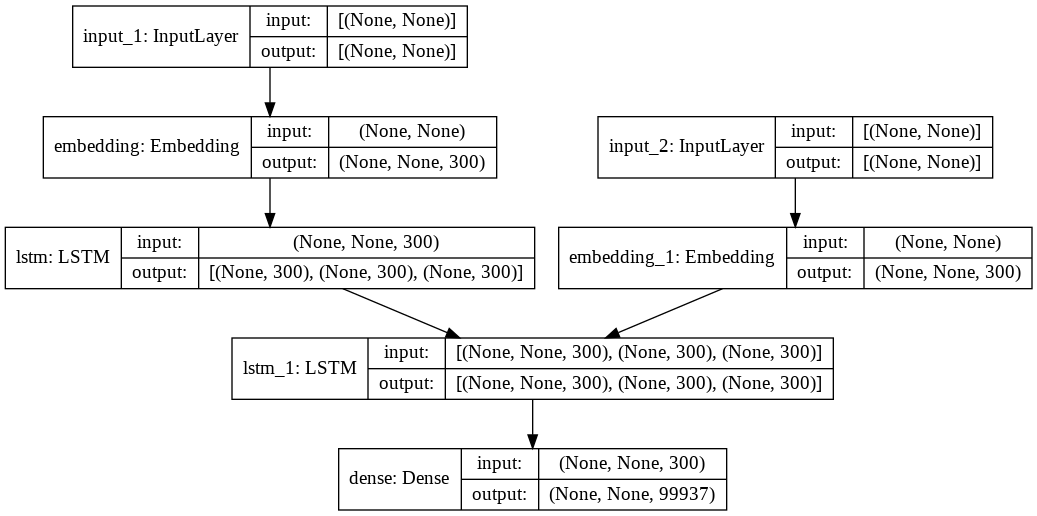

In [33]:
# Plot the model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

In [33]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 128
epochs = 30

s = train_samples/batch_size
v = val_samples/batch_size

In [36]:
# Training the model
history= model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = s,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = v)

# trains for 126 steps and validates for 68 steps

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
126/126 [==============================] - 158s 1s/step - loss: 4.8999 - accuracy: 0.1155 - val_loss: 4.4793 - val_accuracy: 0.1455
Epoch 2/30
126/126 [==============================] - 146s 1s/step - loss: 4.1169 - accuracy: 0.1669 - val_loss: 4.3597 - val_accuracy: 0.1737
Epoch 3/30
126/126 [==============================] - 146s 1s/step - loss: 3.6294 - accuracy: 0.2096 - val_loss: 4.3927 - val_accuracy: 0.1836
Epoch 4/30
126/126 [==============================] - 146s 1s/step - loss: 3.1923 - accuracy: 0.2495 - val_loss: 4.4996 - val_accuracy: 0.1815
Epoch 5/30
126/126 [==============================] - 146s 1s/step - loss: 2.7863 - accuracy: 0.2939 - val_loss: 4.6250 - val_accuracy: 0.1773
Epoch 6/30
126/126 [==============================] - 146s 1s/step - loss: 2.4113 - accuracy: 0.3453 - val_loss: 4.7577 - val_accuracy: 0.1707
Epoch 7/30
126/126 [==============================] - 146s 1s/step - loss: 2.0685 - accuracy: 0.4019 - val_loss: 4.8942 - val_accuracy: 0.1666

In [37]:
print(history.history['loss'])
print(history.history['accuracy'])
print(history.history['val_loss'])
print(history.history['val_accuracy'])

[4.89993143081665, 4.116861820220947, 3.629406690597534, 3.1923093795776367, 2.7862799167633057, 2.4112725257873535, 2.0685386657714844, 1.7620784044265747, 1.4895163774490356, 1.2508964538574219, 1.0627650022506714, 0.9171239137649536, 0.7998698353767395, 0.7050794363021851, 0.6285393834114075, 0.5669769048690796, 0.5116888880729675, 0.46932855248451233, 0.43270328640937805, 0.3975330591201782, 0.3758072257041931, 0.3500286340713501, 0.3324531316757202, 0.3212486207485199, 0.30567410588264465, 0.29626351594924927, 0.283538818359375, 0.27474528551101685, 0.26701611280441284, 0.25800952315330505]
[0.11545439064502716, 0.16689087450504303, 0.2096034437417984, 0.24951335787773132, 0.2939126193523407, 0.3453185260295868, 0.4018915295600891, 0.462123304605484, 0.5280113220214844, 0.5926865935325623, 0.6474709510803223, 0.6880739331245422, 0.7216548919677734, 0.7493859529495239, 0.772872269153595, 0.7909723520278931, 0.8079615831375122, 0.822566032409668, 0.8340772986412048, 0.84564977884292

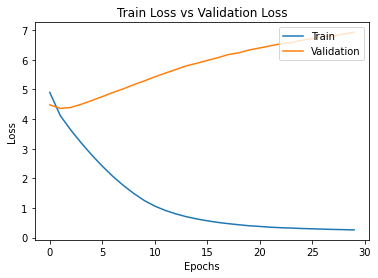

In [38]:
# Plot the Train Loss and Validation
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

> ### **Inference: The above plot shows us that the model has entered an overfit condition.**

In [39]:
model.save_weights('nmt_weights.h5')
model.load_weights('nmt_weights.h5')

In [40]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob distribution over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)


In [41]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

> ## **Testing the Learning Model:**

* Here, we test our model and check for predicted answers.
* We also calculate the BLEU (Bilingual Evaluation Understudy) Score for the model.



In [42]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

In [43]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence1 = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Russian Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Russian Translation:', decoded_sentence1[:-4])

Input English sentence: so china’s “socialism with chinese characteristics” is an economy where an increasing share of national income goes to the state
Actual Russian Translation:  таким образом китайский «социализм с китайским лицом» представляет собой экономику когда увеличивающуюся часть национального дохода получает государство 
Predicted Russian Translation:  таким образом китайский «социализм с китайским ли


In [44]:
from nltk.translate.bleu_score import sentence_bleu
r1= y_train[k:k+1].values[0][6:-4]
c1= decoded_sentence1[:-4]
score1 = sentence_bleu(r1, c1)
print(score1)

0.7400828044922853


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [45]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Russian Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Russian Translation:', decoded_sentence[:-4])

Input English sentence: on one hand technological innovation will be needed to provide increasingly efficient components of lowcarbon climateresilient infrastructure
Actual Russian Translation:  с одной стороны технологические инновации понадобятся для появления новых всё более эффективных компонентов низкоуглеродной климатоустойчивой инфраструктуры 
Predicted Russian Translation:  с одной стороны технологические – должны стреми


In [52]:
from nltk.translate.bleu_score import sentence_bleu
r2= y_train[k:k+1].values[0][6:-4]
c2= decoded_sentence1[:-4]
score2 = sentence_bleu(r2, c2)
print(score2)

0.6848661007688605


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [47]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Russian Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Russian Translation:', decoded_sentence[:-4])

Input English sentence: the british are quite comfortable with ambiguity
Actual Russian Translation:  британцы совершенно довольны этой неопределенностью 
Predicted Russian Translation:  британцы совершенно довольны этой неопределенно


In [53]:
from nltk.translate.bleu_score import sentence_bleu
r3= y_train[k:k+1].values[0][6:-4]
c3= decoded_sentence1[:-4]
score3 = sentence_bleu(r3, c3)
print(score3)

0.6848661007688605


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [49]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Russian Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Russian Translation:', decoded_sentence[:-4])

Input English sentence: economists can help by testing which international rules and institutions are needed to reform an inefficient and often inhumane system
Actual Russian Translation:  экономисты могут помочь определив международные правила и учреждения необходимые для того чтобы реформировать неэффективную и часто бесчеловечную систему 
Predicted Russian Translation:  экономисты могут вызвать и помочь для его последоват


In [54]:
from nltk.translate.bleu_score import sentence_bleu
r4= y_train[k:k+1].values[0][6:-4]
c4= decoded_sentence1[:-4]
score4 = sentence_bleu(r4, c4)
print(score4)

0.6848661007688605


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [51]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Russian Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Russian Translation:', decoded_sentence[:-4])

Input English sentence: religion we are told is responsible for violence oppression poverty and many other ills
Actual Russian Translation:  нам говорят что религия приводит к насилию угнетению нищете и многим другим бедам 
Predicted Russian Translation:  нам говорят что религия приводит к насилию угнет


In [55]:
from nltk.translate.bleu_score import sentence_bleu
r5= y_train[k:k+1].values[0][6:-4]
c5= decoded_sentence1[:-4]
score5 = sentence_bleu(r5, c5)
print(score5)

0.6848661007688605


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [56]:
#BLEU Score for Learning Model 1
score= [score1, score2, score3, score4, score5]

s= np.mean(score)
print('BLEU Score=', s)

BLEU Score= 0.6959094415135454
